In [1]:
import sys
sys.path.append('/Users/pradap/Documents/Research/Python-Package/scaling/dmagellan/')
import pandas as pd

In [2]:
# imports
from dmagellan.blocker.attrequivalence.attr_equiv_blocker import AttrEquivalenceBlocker
from dmagellan.blocker.overlap.overlapblocker_ddf import OverlapBlocker
from dmagellan.blocker.blackbox.blackbox_blocker import BlackBoxBlocker
from dmagellan.blocker.rulebased.rule_based_blocker import RuleBasedBlocker
from dmagellan.feature.autofeaturegen import get_features_for_blocking
from dmagellan.feature.extractfeatures import extract_feature_vecs
from dmagellan.feature.autofeaturegen import get_features_for_matching
from dmagellan.matcher.dtmatcher import DTMatcher
from dmagellan.utils.py_utils.utils import concat_df
from dask import delayed
from dask.threaded import get
from distributed import Client
import py_entitymatching as em

/Users/pradap/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# client = Client('127.0.0.1:8786')

In [3]:
from dask import dataframe as dd

In [15]:
orig_A = dd.read_csv('./data/citeseer_nonans.csv', usecols=['id', 'title'])
orig_B = dd.read_csv('./data/dblp_nonans.csv', usecols=['id', 'title'])


In [16]:
A = dd.read_csv('./data/sample_citeseer.csv', usecols=['id', 'title'], blocksize=400000)
B = dd.read_csv('./data/sample_dblp.csv', usecols=['id', 'title'], blocksize=400000)

In [17]:
orig_A.npartitions, orig_B.npartitions

(4, 5)

In [18]:
# help(dd.read_csv)

In [43]:
# blocking
ob = OverlapBlocker()
C = ob.block_tables(A, B, 'id', 'id', 'title', 'title', 
                    overlap_size=4, nltable_chunks=A.npartitions, nrtable_chunks=B.npartitions, 
                    scheduler=get, compute=False, 
                    rem_stop_words=True
                   )
# len(C)

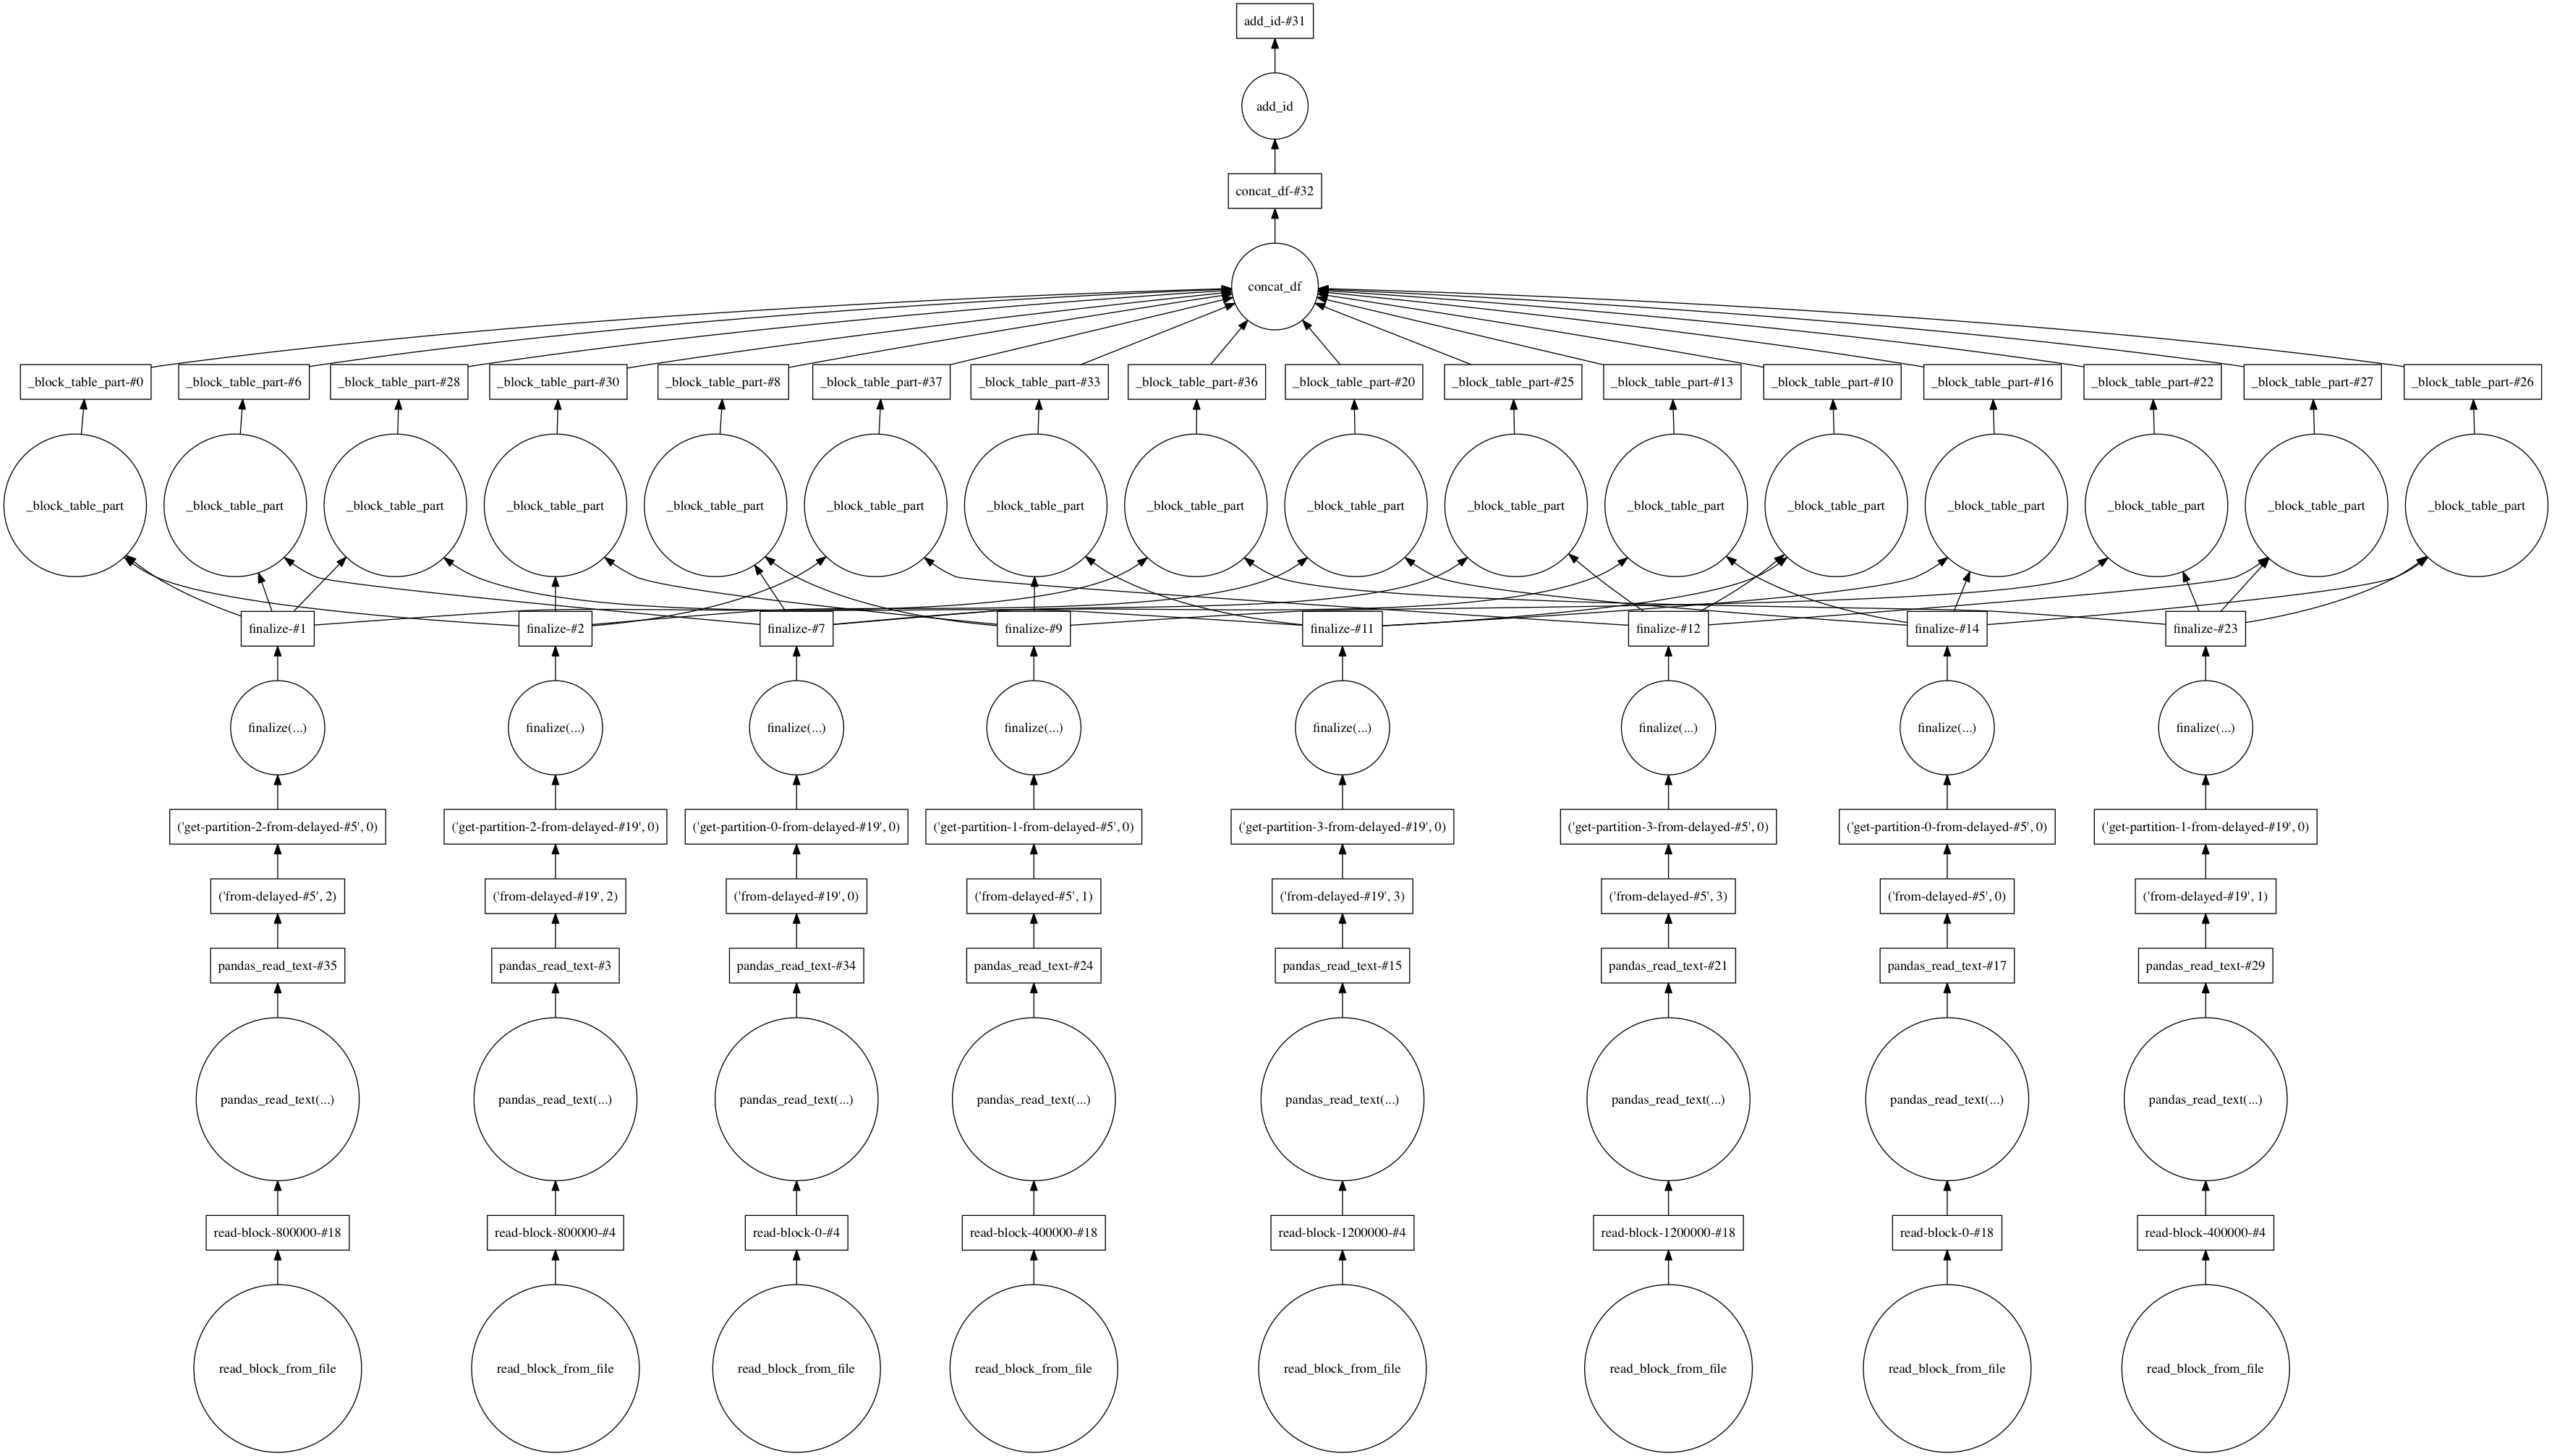

In [21]:
C.visualize()

In [22]:
client = Client('127.0.0.1:8786')

In [23]:
D = C.compute(get=client.get, optimize_graph=False)

In [24]:
len(D)

357

In [25]:
L = pd.read_csv('./data/sample_labeled_data.csv')
L = L[['_id', 'l_id', 'r_id', 'label']]

In [26]:
F = get_features_for_matching(orig_A.compute(), orig_B.compute())

In [27]:
F

,feature_name,left_attribute,right_attribute,left_attr_tokenizer,right_attr_tokenizer,simfunction,function,function_source,is_auto_generated
0,id_id_exm,id,id,None,None,exact_match,<function id_id_exm at 0x133eb66e0>,from dmagellan.feature.simfunctions import *\nfrom dmagellan.feature.tokenizers import *\ndef id...,True
1,id_id_anm,id,id,None,None,abs_norm,<function id_id_anm at 0x177575cf8>,from dmagellan.feature.simfunctions import *\nfrom dmagellan.feature.tokenizers import *\ndef id...,True
2,id_id_lev_dist,id,id,None,None,lev_dist,<function id_id_lev_dist at 0x177575de8>,from dmagellan.feature.simfunctions import *\nfrom dmagellan.feature.tokenizers import *\ndef id...,True
3,id_id_lev_sim,id,id,None,None,lev_sim,<function id_id_lev_sim at 0x177575c08>,from dmagellan.feature.simfunctions import *\nfrom dmagellan.feature.tokenizers import *\ndef id...,True
4,title_title_jac_qgm_3_qgm_3,title,title,qgm_3,qgm_3,jaccard,<function title_title_jac_qgm_3_qgm_3 at 0x177575b90>,from dmagellan.feature.simfunctions import *\nfrom dmagellan.feature.tokenizers import *\ndef ti...,True
5,title_title_cos_dlm_dc0_dlm_dc0,title,title,dlm_dc0,dlm_dc0,cosine,<function title_title_cos_dlm_dc0_dlm_dc0 at 0x177575b18>,from dmagellan.feature.simfunctions import *\nfrom dmagellan.feature.tokenizers import *\ndef ti...,True
6,title_title_mel,title,title,None,None,monge_elkan,<function title_title_mel at 0x177575aa0>,from dmagellan.feature.simfunctions import *\nfrom dmagellan.feature.tokenizers import *\ndef ti...,True
7,title_title_lev_dist,title,title,None,None,lev_dist,<function title_title_lev_dist at 0x177575a28>,from dmagellan.feature.simfunctions import *\nfrom dmagellan.feature.tokenizers import *\ndef ti...,True
8,title_title_lev_sim,title,title,None,None,lev_sim,<function title_title_lev_sim at 0x1775759b0>,from dmagellan.feature.simfunctions import *\nfrom dmagellan.feature.tokenizers import *\ndef ti...,True


In [ ]:
# help(extract_feature_vecs)

In [28]:
L.head()

,_id,l_id,r_id,label
0,0,401372,1446376,0
1,1,1349544,12210,1
2,2,1328193,1921746,1
3,3,824620,1311578,0
4,4,1100045,535453,0


In [29]:
# Convert L into feature vectors using updated F
H = extract_feature_vecs(L, orig_A, orig_B, 
                         '_id', 'l_id', 'r_id', 'id', 'id', 
                          feature_table=F, 
                          attrs_after='label', nchunks=4,
                          show_progress=True, compute=True, 
                         scheduler=client.get)

In [ ]:
# client.restart()

In [10]:
H.head()

,_id,l_id,r_id,id_id_exm,id_id_anm,id_id_lev_dist,id_id_lev_sim,title_title_jac_qgm_3_qgm_3,title_title_cos_dlm_dc0_dlm_dc0,title_title_mel,title_title_lev_dist,title_title_lev_sim,authors_authors_jac_qgm_3_qgm_3,authors_authors_cos_dlm_dc0_dlm_dc0,authors_authors_mel,authors_authors_lev_dist,authors_authors_lev_sim,label
0,0,401372,1446376,0,0.277502,4,0.428571,0.101604,0.181902,0.707672,94.0,0.318841,0.000000,0.000000,0.514006,26.0,0.235294,0
1,1,1349544,12210,0,0.009048,6,0.142857,0.828571,0.714286,0.916532,2.0,0.968750,0.580000,0.676123,0.864320,14.0,0.695652,1
2,2,1328193,1921746,0,0.691139,5,0.285714,0.900000,0.800000,0.995833,1.0,0.979167,1.000000,1.000000,1.000000,0.0,1.000000,1
3,3,824620,1311578,0,0.628724,7,0.000000,0.104762,0.223607,0.590867,56.0,0.125000,0.092593,0.000000,0.640811,50.0,0.253731,0
4,4,1100045,535453,0,0.486756,6,0.142857,0.215116,0.333333,0.695030,108.0,0.239437,0.010101,0.000000,0.525752,58.0,0.205479,0


In [31]:

# Instantiate the matcher to evaluate.
dt = DTMatcher(name='DecisionTree', random_state=0)

In [44]:
dt.fit(table=H, 
       exclude_attrs=['_id', 'l_id', 'r_id', 'label'], 
       target_attr='label')

In [46]:
# Convert J into a set of feature vectors using F
I = extract_feature_vecs(C, A, B,
                         '_id', 'l_id', 'r_id', 'id', 'id', 
                            nchunks=3,
                            feature_table=F,
                            
                            show_progress=False,
                            compute=False)

In [ ]:
# help(dt.predict)

In [47]:
predictions = dt.predict(table=I, exclude_attrs=['_id', 'l_id', 'r_id'], 
              append=True, target_attr='predicted', inplace=False,
                        nchunks=3, scheduler=client.get, compute=False, show_progress=True)

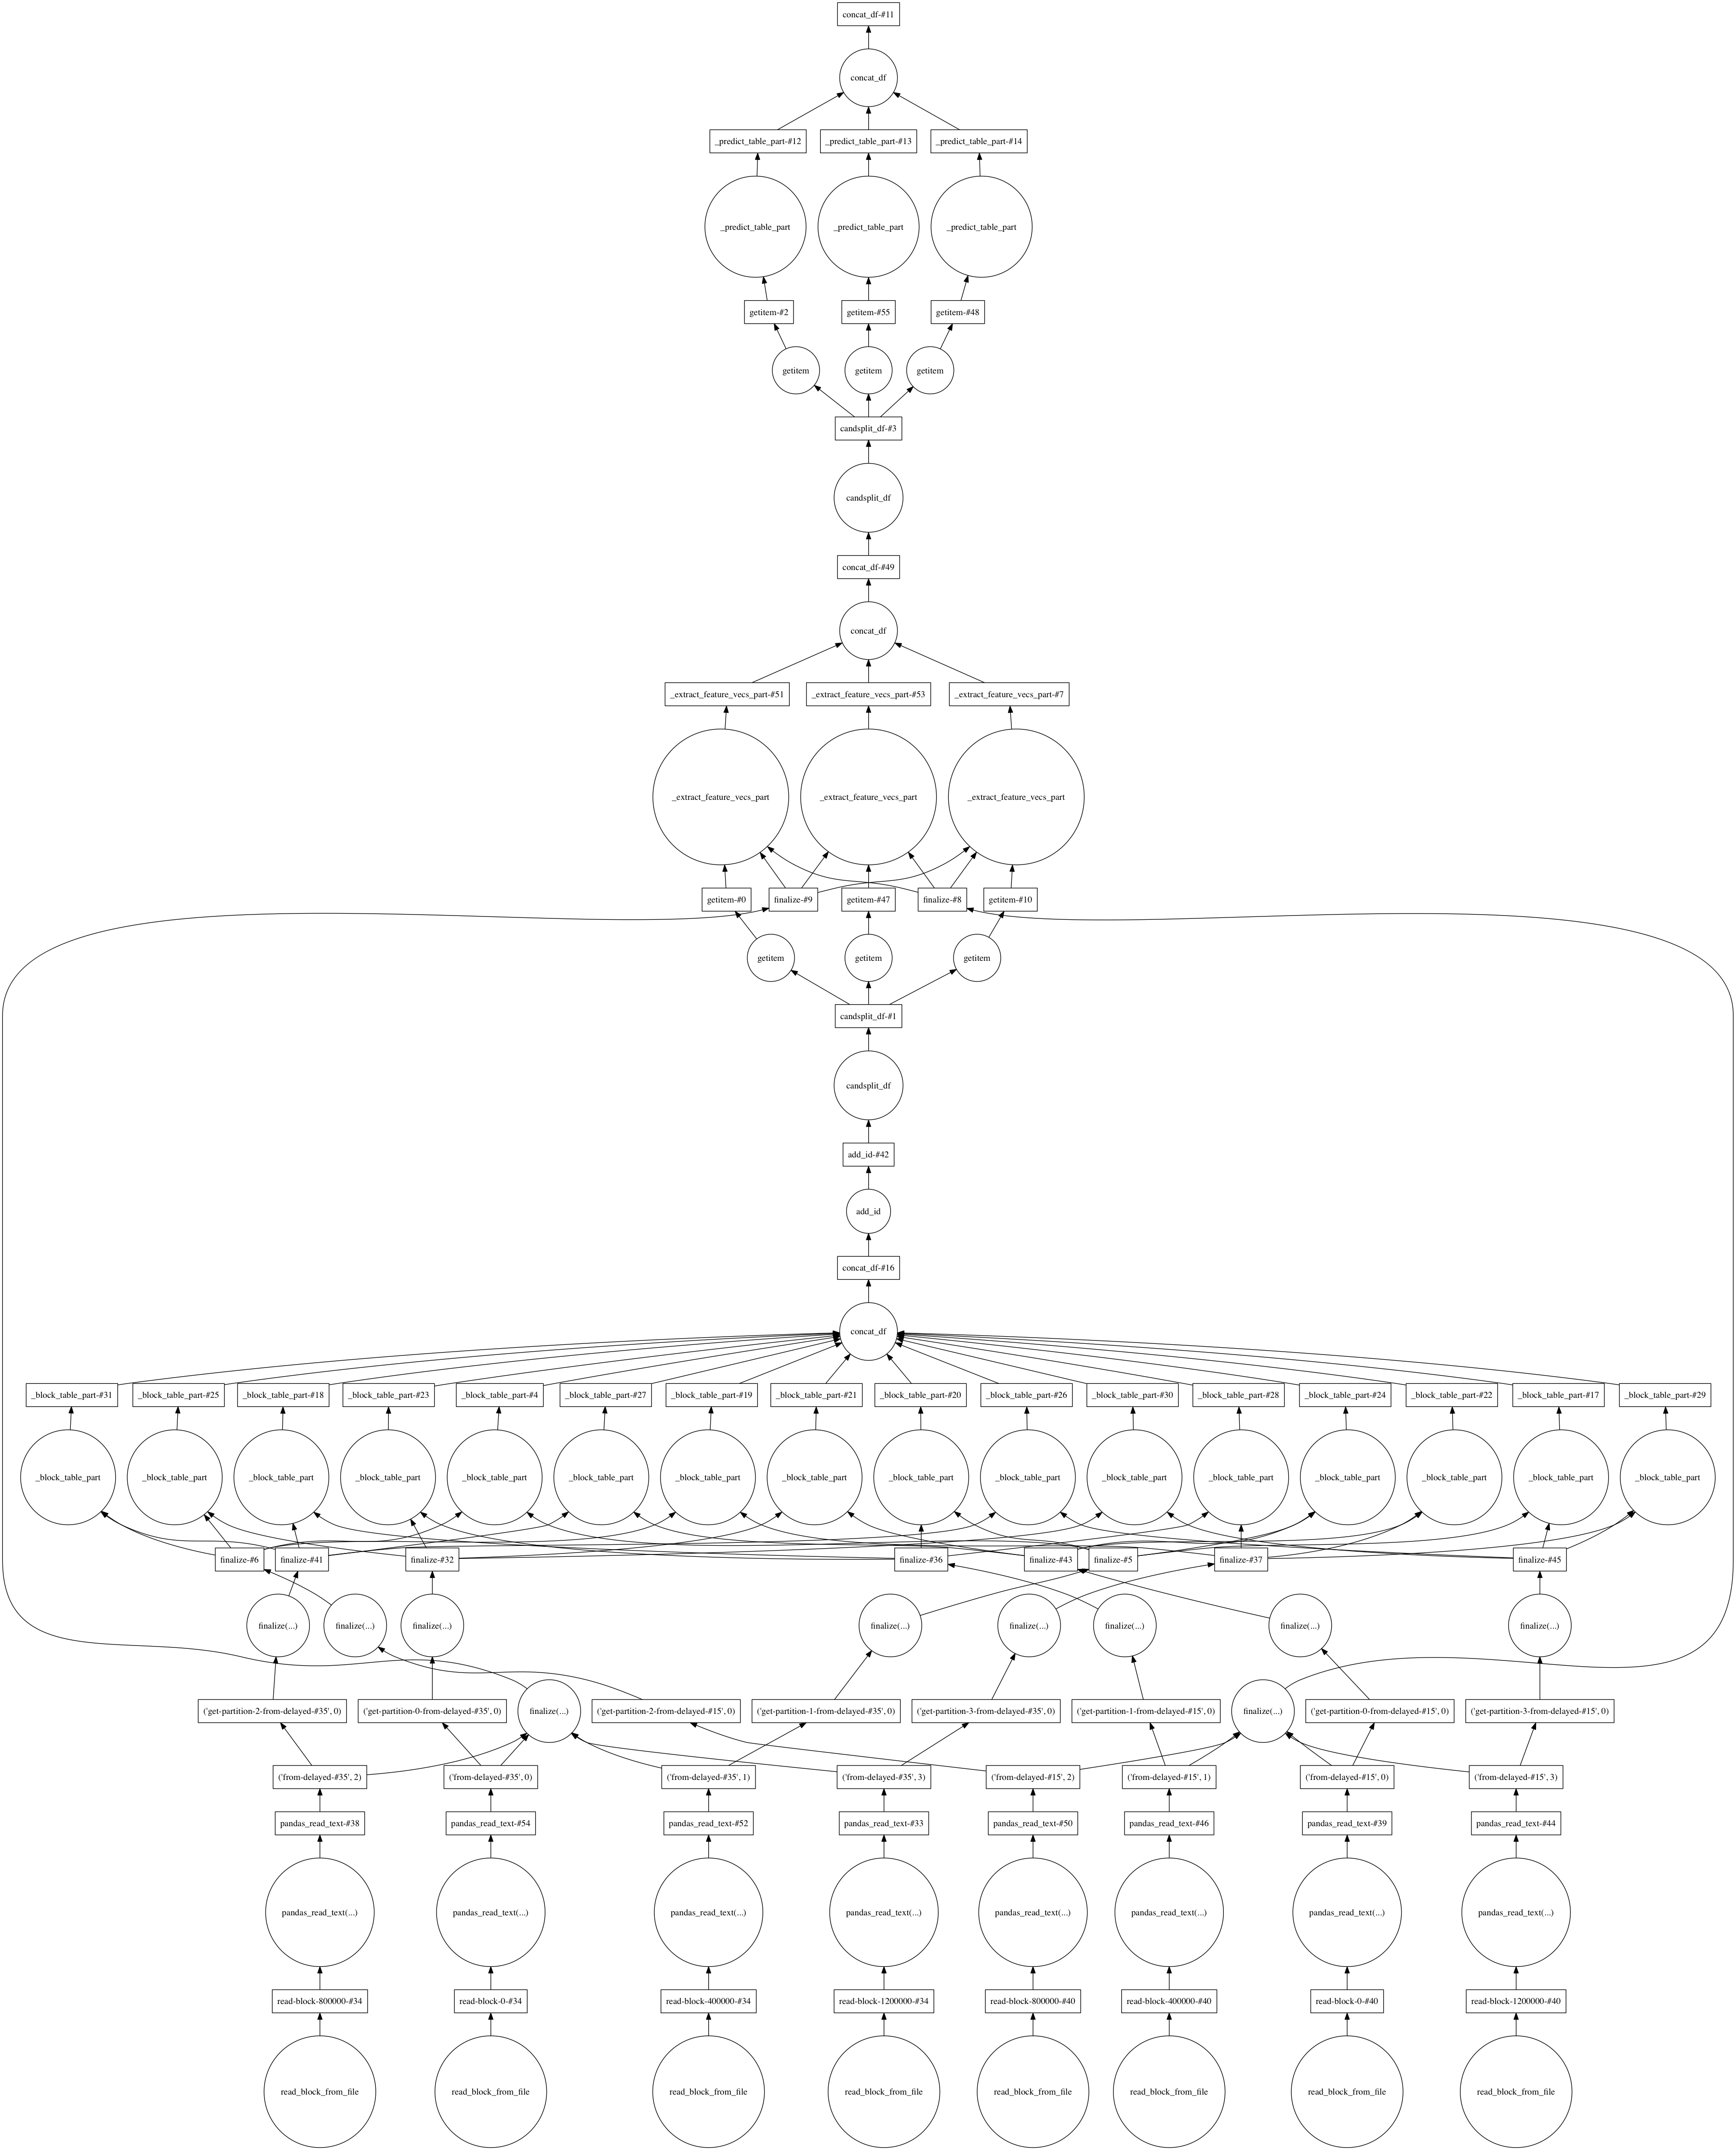

In [48]:
predictions.visualize()

In [49]:
p = predictions.compute(get=client.get)

In [50]:
p.predicted.sum()

32

In [22]:
from time import time
t = time()
x = 0
for i in range(100000):
    x = x+1
print(time()-t)


0.0357918739319


In [22]:
from time import time
t1 = time()
p = C.compute(get=client.get)
print(time()-t1)

2.10364699364


In [ ]:
# predictions.predicted.sum()